In [4]:
import pandas as pd
import numpy as np
from os import listdir, walk
from os.path import isfile, join
import matplotlib.pyplot as plt
from copy import deepcopy
from statsmodels.stats.multitest import multipletests
from scipy import stats
from itertools import combinations
from matplotlib.offsetbox import AnchoredText

### Constants for the file

* ```SUBJECT_IDS```: list of subject ids to use for the analysis. Please note that the folder of the subject must have the same number. Ex. If you give 0, then ```Experiment/Subject 0/``` must exists.
* ```PATH```: Folder where it contains the Subject data. Ex: ```../Data/Experiment/Subject 0/RL``` => Please give ```../Data/Experiment/```.

**To change the number of files to read, please change the ids in SUBJECT_IDS**

In [5]:
SUBJECT_IDS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
PATH = '../Data/Experiment/'

### Functions

In [6]:
def load_file_for_subject(subject_id):
    """
    Loads the UCB and Staircases dataframe of 1 subject.

    Parameters
    ----------
    subject_id : int
        Id of the subject's file to load
        
    Returns
    -------
    ucb : dataframe
        UCB dataframe
    staircases : array of dataframe
        Array of staircase dataframe
    """
    
    # Paths
    dir_path = '{}Subject {}/RL/'.format(PATH, subject_id)    
    paths = [dir_path + f for f in listdir(dir_path) if isfile(join(dir_path, f))]
    dir_path += 'Python/'
    paths2 = [dir_path + f for f in listdir(dir_path) if isfile(join(dir_path, f)) and f.endswith('.csv')]
    paths.extend(paths2)
    paths = sorted(paths)
    
    # Load files
    ucb = pd.read_csv(paths[0])
    staircases = [pd.read_csv(f) for f in paths[2:]]
    
    return ucb, staircases

def load_position():
    """
    Loads the position csv for all the subjects in SUBJECT_IDS

    Parameters
    ----------
    None
        
    Returns
    -------
    positions: array of dataframes
        All the normal positions dataframes of SUBJECT_IDS
    abnormals: array of dataframes
        All the abnormal positions dataframes of SUBJECT_IDS
    normal_times: array of float
        All the normal durations
    ab_times: array of float
        All the abnormal durations
    ab_paths: array of str
        All the paths of the abnormal files
    """
    positions = []
    abnormals = []
    ab_paths = []
    ab_times = []
    normal_times = []
    for subject_id in SUBJECT_IDS:
        dir_path = '{}Subject {}/Positions/'.format(PATH, subject_id)    
        paths = [dir_path + f for f in listdir(dir_path) if isfile(join(dir_path, f)) and "Block0" not in f]
        paths = sorted(paths)        
        
        # Load files & get the duration of each trial
        # Note down the files that are abnormal
        for p in paths:
            df = pd.read_csv(p)
            time = df['Time (s)']
            diff = time.iloc[-1] - time.iloc[0]
            if diff > 10 or diff < 4:
                abnormals.append(df)
                ab_paths.append(p)
                ab_times.append(diff)
            else:
                normal_times.append(diff)
                positions.append(df)
    
    return positions, normal_times, abnormals, ab_times, ab_paths


def get_convergence_values_for_subject(df, df2s):
    """
    Return the convergence values for UCB and 4 staircases of a subject.
    Also returns the nb of staircase that did not converge and if the UCB
    algorithm converged under 100 trials or not
    
    Parameters
    ----------
    df : dataframe
        UCB dataframe of a subject
    df2 : array of dataframes
        Staircases dataframes of a subject
        
    Returns
    -------
    staircase_vals : array of float
        Array containing <= 4 distortion gain found by the converged staircase 
    ucb_val : float
        Distortion gain found by the UCB algorithm
    staircase_not_conv: int
        Nb of staircase that did not converge
    ucb_converged: boolean
        True if the UCB converged under 100 iterations.
    """
    # Get the ucb convergence threshold
    try:
        ucb_val = df[df.converged == True].gain.iloc[0]
        ucb_converged = True
    except:
        ucb_val = df.gain.iloc[-1]
        ucb_converged = False
    # Get the 
    staircase_vals = [] 
    staircase_not_conv = 0
    for i, s in enumerate(df2s):
        try:
            staircase_vals.append(float(s.iloc[-1].subjectid.split(':')[1].strip()))
        except:
            staircase_not_conv += 1
    return staircase_vals, ucb_val, staircase_not_conv, ucb_converged


def perc_corrected(df):
    """
    Calculate number of times corrected & corrected ucb.
    
    Parameters
    ----------
    df: dataframe
        A UCB dataframe of a subject
    Returns
    -------
    Percentage of the trials that has been corrected (during the trials of UCB only) 
    
    """
    no_wrong = (df.original_detected != df.detected).sum()
    no_trial = (df.converged == False).sum()
    return no_wrong / no_trial * 100

def get_convergence_values():
    """
    Return the convergence values for UCB and 4 staircases of all subject in SUBJECT_IDS
    Staircases that did not converge are discarded.
    
    Parameters
    ----------
    None
        
    Returns
    -------
    ucb_vals : array of float
        Array containing 21 distortion gain found by the UCB
    staircase_vals : array of array of float
        Array containing 21 arrays of <=4 distortion gain found by the converged staircases.
        ex.:[[2.5, 2], [2, 4, 5, 3], [3], ...]
    """
    
    ucb_vals = []
    staircase_vals = []
    for i in SUBJECT_IDS:
        ucb, staircases = load_file_for_subject(i)
        staircase_val, ucb_val, _, _ = get_convergence_values_for_subject(ucb, staircases)
        ucb_vals.append(ucb_val)
        staircase_vals.append(staircase_val)
    return ucb_vals, staircase_vals

def get_convergence_values_for_subject_spearman(df, df2s):
    """
    Return the convergence values for UCB and 4 staircases of a subject
    For staircases that did not converge, we take the mean of the gains of the last 2 turns.
    
    Parameters
    ----------
    df : dataframe
        UCB dataframe of a subject
    df2 : array of dataframes
        Staircases dataframes of a subject
        
    Returns
    -------
    staircase_vals : array of float
        Array containing <= 4 distortion gain found by the converged staircase 
    ucb_val : float
        Distortion gain found by the UCB algorithm
    nb_not_conv_staircase: int
        Nb staircases that did not converge
    """
    nb_not_conv_staircase = 0
    try:
        ucb_val = df[df.converged == True].gain.iloc[0]
    except:
        ucb_val = df.gain.iloc[-1]
    staircase_vals = [] 
    for i, s in enumerate(df2s):
        try:
            staircase_vals.append(float(s.iloc[-1].subjectid.split(':')[1].strip()))
        except:
            gain_points = s[s.isturn == True][-2:].gain.values
            dotx = s[s.isturn == True].trial[-2:].values
            conv_val = gain_points.mean()
            x = np.arange(len(s.gain[:-1]))
            staircase_vals.append(conv_val) # take the last 2 turns & calculate mean
            nb_not_conv_staircase += 1
    return staircase_vals, ucb_val, nb_not_conv_staircase

def get_spearman_convergence_values():
    """
    Return the convergence values for UCB and 4 staircases of all subject in SUBJECT_IDS
    For staircases that did not converge, we take the mean of the gains of the last 2 turns.
    
    Parameters
    ----------
    None
        
    Returns
    -------
    ucb_sp_vals : array of float
        Array containing 21 distortion gain found by the UCB
    staircase_sp_vals : array of array of float
        Array containing 21 arrays of <=4 distortion gain found by the staircases.
        ex.:[[2.5, 2], [2, 4, 5, 3], [3], ...]
    nb_not_conv_staircases : array of int
        Nb staircases that did not converge per subject
    """
    nb_not_conv_staircases = []
    staircase_sp_vals = []
    ucb_sp_vals = []
    for i in SUBJECT_IDS:
        ucb, staircase = load_file_for_subject(i)
        staircase_val, ucb_val, nb_not_conv_staircase = get_convergence_values_for_subject_spearman(ucb, staircase)
        staircase_sp_vals.append(staircase_val)
        nb_not_conv_staircases.append(nb_not_conv_staircase)
    return staircase_sp_vals, ucb_sp_vals, nb_not_conv_staircases

def robustness_conservativeness_staircase(df, df2, conv_val):
    """
    Calculate the robustness % and the correctness % of a staircase threshold
    
    Parameters
    ----------
    df: dataframe
        UCB dataframe of a subject
    df2: array of dataframes
        Staircase dataframes of a subject
    conv_val:
        A staircase distortion threshold
        
    Returns
    -------
    arg1:
        Robustness in % for the conv_val threshold 
    arg2:
        Conservativeness in % for the conv_val threshold
    """
    # Total number of trials
    total_trials = len(df) + len(df2) - 5 # - 5 for 5 lines noting conv
    # Robustness (count)
    times_low_detected = len(df[(df.gain <= conv_val) & (df.detected == True)]) + len(df2[(df2.gain <= conv_val) & (df2.original_detected == True)])
    # Conservativeness (count)
    times_high_not_detected = len(df[(df.gain > conv_val) & (df.detected == False)]) + len(df2[(df2.gain > conv_val) & (df2.original_detected == False)])
    
    return times_low_detected / total_trials * 100, times_high_not_detected / total_trials * 100


def robustness_conservativeness_ucb(df2, df, conv_val):
    """
    Calculate the robustness % and the correctness % of a staircase threshold
    
    Parameters
    ----------
    df: dataframe
        UCB dataframe of a subject
    df2: array of dataframes
        Staircase dataframes of a subject
    conv_val:
        A staircase distortion threshold
        
    Returns
    -------
    arg1:
        Robustness in % for the conv_val threshold 
    arg2:
        Conservativeness in % for the conv_val threshold
    """
    total_length = len(df) + len(df2) - 5 # - 5 for 5 lines noting conv
    times_low_detected = len(df[(df.gain <= conv_val) & (df.detected == True)]) + len(df2[(df2.gain <= conv_val) & (df2.original_detected == True)])
    times_high_not_detected = len(df[(df.gain > conv_val) & (df.detected == False)]) + len(df2[(df2.gain > conv_val) & (df2.original_detected == False)])
    return times_low_detected / total_length * 100, times_high_not_detected / total_length * 100


def get_table_thresholds(ucb_vals, staircase_vals):
    col1 = [] # 1. Valeurs de staircase le plus robuste => le staircase ak le plus petit valeur pour le 1er pourcentage
    col2 = [] # 2. Valeurs de staircase le moins stricte => le plus petit pour valeur pour le 2e pourcentage 
    col3 = [] # 3. Compris de 1+2 => calcule la difference entre les 2 valeurs, prend celui ak le min difference.
    col4 = deepcopy(list(np.array(ucb_vals)[SUBJECT_IDS])) # Valeurs de UCB directement
    print("UCB values: {}".format(col4))

    for i in SUBJECT_IDS:
        ucb, staircases = load_file_for_subject(i)

        staircase_concat = pd.concat(staircases)

        # Merge staircase into a large df
        staircase_low = []
        staircase_high = []
        staircase_diff = []
        for j, v in enumerate(staircase_vals[i]):
            perc_low_detected, perc_high_not_detected = robustness_conservativeness_staircase(staircase_concat, ucb, v)
            staircase_low.append(perc_low_detected)
            staircase_high.append(perc_high_not_detected)
            staircase_diff.append(np.abs(perc_high_not_detected - perc_low_detected))

            print("For subject {} staircase {}, distortion_threshold: {}, robustness: {}%, conservativeness: {}%".format(i, j, v, perc_low_detected, perc_high_not_detected))

        # Transform into numpy arrays
        staircase_low = np.array(staircase_low)
        staircase_high = np.array(staircase_high)
        staircase_diff = np.array(staircase_diff)
        staircase_values = np.array(staircase_vals[i])

        # Col 1
        indices_low = np.where(staircase_low == staircase_low.min())
        robust_val = staircase_values[indices_low].mean()
        col1.append(robust_val)

        # Col 2
        indices_high = np.where(staircase_high == staircase_high.min())
        conservative_val = staircase_values[indices_high].mean()
        col2.append(conservative_val)

        # Col 3
        indices_diff = np.where(staircase_diff == staircase_diff.min())
        diff_val = staircase_values[indices_diff].mean()
        col3.append(diff_val)

        print("Most robust staircase: indices - ({}), value: {}; Least conservative staircase: indices - ({}), value: {}; In middle-staircase: indices - ({}), value: {}\n"\
              .format(indices_low[0], robust_val, indices_high[0], conservative_val, indices_diff[0], diff_val))
        
    return [col1, col2, col3, col4]

In [7]:
def get_robust_table(ucb_vals, staircase_vals):
    """Same thing, for robustness %"""
    col1 = [] # Valeurs de staircase le plus robuste => le staircase ak le plus petit valeur pour le 1er pourcentage
    col2 = [] # 2. Valeurs de staircase le moins stricte => le plus petit pour valeur pour le 2e pourcentage 
    col3 = [] # 3. Compris de 1+2 => calcule la difference entre les 2 valeurs, prend celui ak le min difference.
    col4 = [] # Valeurs de Rl

    for i in SUBJECT_IDS:
        ucb, staircases = load_file_for_subject(i)
        
        staircase_concat = pd.concat(staircases)
        
        ucb_low_detected, ucb_high_detected = robustness_conservativeness_ucb(ucb, staircase_concat, ucb_vals[i])
        col4.append(ucb_low_detected)
        print("For subject {} ucb threshold: {}, Robustness: {}%, Conservativeness: {}%".format(i, ucb_vals[i], ucb_low_detected, ucb_high_detected))


        # Merge staircase into a large df
        staircase_low = []
        staircase_high = []
        staircase_diff = []
        for j, v in enumerate(staircase_vals[i]):
            perc_low_detected, perc_high_not_detected = robustness_conservativeness_staircase(staircase_concat, ucb, v)
            staircase_low.append(perc_low_detected)
            staircase_high.append(perc_high_not_detected)
            staircase_diff.append(np.abs(perc_high_not_detected - perc_low_detected))

            print("For subject {} staircase {}, threshold: {}, Robustness: {}%, Conservativeness: {}%".format(i, j, v, perc_low_detected, perc_high_not_detected))

        # Transform into numpy arrays
        staircase_low = np.array(staircase_low)
        staircase_high = np.array(staircase_high)
        staircase_diff = np.array(staircase_diff)
        staircase_values = np.array(staircase_vals[i])

        # Col 1
        indices_low = np.where(staircase_low == staircase_low.min())
        robust_val = staircase_low[indices_low].mean()
        col1.append(robust_val)

        # Col 2
        indices_high = np.where(staircase_high == staircase_high.min())
        conservative_val = staircase_low[indices_high].mean()
        col2.append(conservative_val)

        # Col 3
        indices_diff = np.where(staircase_diff == staircase_diff.min())
        diff_val = staircase_low[indices_diff].mean()
        col3.append(diff_val)
        
        print("Most robust staircase: {}, Least conservative staircase: {}, In middle-staircase: {}, UCB value: {}\n".format(robust_val, conservative_val, diff_val, ucb_low_detected))

#         print("Robuste: indices - ({}), value: {}; Conservative: indices - ({}), value: {}; Col3: indices - ({}), value: {}\n"\
#               .format(indices_low[0], robust_val, indices_high[0], conservative_val, indices_diff[0], diff_val))
        
    return [col1, col2, col3, col4]

In [8]:
def get_conservative_table(ucb_vals, staircase_vals):
    """Same thing, for conservativeness %"""
    col1 = [] # Valeurs de staircase le plus robuste => le staircase ak le plus petit valeur pour le 1er pourcentage
    col2 = [] # 2. Valeurs de staircase le moins stricte => le plus petit pour valeur pour le 2e pourcentage 
    col3 = [] # 3. Compris de 1+2 => calcule la difference entre les 2 valeurs, prend celui ak le min difference.
    col4 = [] # Valeurs de Rl

    for i in SUBJECT_IDS:
        ucb, staircases = load_file_for_subject(i)

        staircase_concat = pd.concat(staircases)
        
        ucb_low_detected, ucb_high_detected = robustness_conservativeness_ucb(ucb, staircase_concat, ucb_vals[i])
        col4.append(ucb_high_detected)
        print("For subject {} ucb threshold: {}, Robustness: {}%, Conservativeness: {}%".format(i, ucb_vals[i], ucb_low_detected, ucb_high_detected))

        # Merge staircase into a large df
        staircase_low = []
        staircase_high = []
        staircase_diff = []
        for j, v in enumerate(staircase_vals[i]):
            perc_low_detected, perc_high_not_detected = robustness_conservativeness_staircase(staircase_concat, ucb, v)
            staircase_low.append(perc_low_detected)
            staircase_high.append(perc_high_not_detected)
            staircase_diff.append(np.abs(perc_high_not_detected - perc_low_detected))

            print("For subject {} staircase {}, Threshold: {}, Robustness: {}%, Conservativeness: {}%".format(i, j, v, perc_low_detected, perc_high_not_detected))

        # Transform into numpy arrays
        staircase_low = np.array(staircase_low)
        staircase_high = np.array(staircase_high)
        staircase_diff = np.array(staircase_diff)
        staircase_values = np.array(staircase_vals[i])

        # Col 1
        indices_low = np.where(staircase_low == staircase_low.min())
        robust_val = staircase_high[indices_low].mean()
        col1.append(robust_val)

        # Col 2
        indices_high = np.where(staircase_high == staircase_high.min())
        conservative_val = staircase_high[indices_high].mean()
        col2.append(conservative_val)

        # Col 3
        indices_diff = np.where(staircase_diff == staircase_diff.min())
        diff_val = staircase_high[indices_diff].mean()
        col3.append(diff_val)
        
        print("Most robust staircase: {}, Least conservative staircase: {}, In middle-staircase: {}, UCB value: {}\n".format(robust_val, conservative_val, diff_val, ucb_low_detected))

    return [col1, col2, col3, col4]

In [9]:
def convergence_speed():
    """
    Calculate and plot the nb iterations for the UCB and Staircase algorithms 
    
    Parameters
    ----------
    None
        
    Returns
    -------
    arg1:
        Robustness in % for the conv_val threshold 
    arg2:
        Conservativeness in % for the conv_val threshold
    """
    ucb_len = []
    staircase_len = []
    nb_not_conv_staircase = []
    for i in SUBJECT_IDS:
        ucb, staircases = load_file_for_subject(i)
        ucb_len.append(len(ucb) - 1) # -1 cuz last line only record convergence
        s_len = 0
        staircase_not_conv = 0
        for j, s in enumerate(staircases):
            s_len += len(s) - 1 # -1 cuz last line only record convergence

            try:
                unused_value = float(s.iloc[-1].subjectid.split(':')[1].strip())
            except:
                print("Subject {} - Staircase {}: {}".format(i, j, s.iloc[-1].subjectid.split(':')[0]))
                staircase_not_conv += 1

        nb_not_conv_staircase.append(staircase_not_conv)
        staircase_len.append(s_len)


    print("It takes in average {} iterations, std: {}, variance: {} for UCB to conv (for 21 subjects)".format(np.mean(ucb_len), np.std(ucb_len), np.var(ucb_len)))
    print("It takes in average {} iterations, std: {}, variance: {} for STAIRCASE to conv (for 21 subjects)".format(np.mean(staircase_len), np.std(staircase_len), np.var(staircase_len)))
    print("There are total {} ( {}% ) staircases that did not converge, in average {} staircases per subject, std: {}, variance: {}".format(sum(nb_not_conv_staircase), sum(nb_not_conv_staircase)/84 * 100, np.mean(nb_not_conv_staircase), np.std(nb_not_conv_staircase), np.var(nb_not_conv_staircase)))
    
    plt.bar(['UCB', 'Staircase'], [np.mean(ucb_len), np.mean(staircase_len)], yerr=[np.std(ucb_len)/np.sqrt(21), np.std(staircase_len)/np.sqrt(21)], align='center', alpha=0.5, ecolor='black', capsize=10)
    plt.ylabel('Iterations')
    plt.grid(True)
    plt.show()

## Statistical functions

#### Shapiro-Wilk test for each group

The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution.

alpha = 0.05 => if > 0.05 then Gaussian (fail to reject H0); else: not Gaussian

In [10]:
def shapiro_tests(cols):
    """
    Apply Shapiro-Wilk normality test each of the columns.
    
    Parameters
    ----------
    cols: tables of values
        [col1, col2, col3, col4] built in get_table_xxx() functions
        
    Returns
    -------
    Print out the Stats and p-value of the Shapiro Normality test for each col.
    """
    alpha = 0.05
    for i, col in enumerate(cols):
        stat, p = stats.shapiro(col)
        print("For col {} stats: {}, p-value: {}".format(i + 1, stat, p))
        if p > alpha:
            print('Gaussian (fail to reject H0)\n')
        else:
            print('Not Gaussian (reject H0)\n')

#### Friedman test

The Friedman test tests the null hypothesis that repeated measurements of the same individuals have the same distribution. It is often used to test for consistency among measurements obtained in different ways. For example, if two measurement techniques are used on the same set of individuals, the Friedman test can be used to determine if the two measurement techniques are consistent.

p <= alpha: reject H0, different distribution.

p > alpha: fail to reject H0, same distribution.

In [11]:
def friedman_test(cols):
    """
    Apply Friedman test on the tables.
    
    Parameters
    ----------
    cols: tables of values
        [col1, col2, col3, col4] built in get_table_xxx() functions
        
    Returns
    -------
    Print out the Stats and p-value of the test.
    """
    stat, p = stats.friedmanchisquare(cols[0], cols[1], cols[2], cols[3])
    print('Statistics={}, p={}'.format(stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Same distributions (fail to reject H0)\n')
    else:
        print('Different distributions (reject H0)\n')

#### Wilcoxon test

The Wilcoxon test, which refers to either the Rank Sum test or the Signed Rank test, is a nonparametric statistical test that compares two paired groups. The test essentially calculates the difference between each set of pairs and analyzes these differences.

The Wilcoxon Signed Rank test assumes that there is information in the magnitudes and signs of the differences between paired observations. As the nonparametric equivalent of the paired student's t-test, the Signed Rank can be used as an alternative to the t-test when the population data does not follow a normal distribution.

H0: No difference between means (p >= 0.05)

Ha: Difference between means (p < 0.05)

In [12]:
def wilcoxon_test(cols, col_nbs='0123'):
    """
    Apply Wilcoxon test on each pair of the columns.
    
    Parameters
    ----------
    cols: tables of values
        [col1, col2, col3, col4] built in get_table_xxx() functions
    col_nbs: str
        A string having all the column numbers. By default, we have 4 columns => '0123'
    
    Returns
    -------
    Print out the Stats and p-value of the test.
    
    p_values: array of float
        An array containing the p-values of each pairwise test.
    
    """
    p_values = []
    for i, j in list(combinations(col_nbs, 2)):
        a = int(i)
        b = int(j)
        c1 = cols[a]
        c2 = cols[b]

        stat, p = stats.wilcoxon(c1, c2)
        print('For col {} - col {} : Statistics={}, p={}'.format(a, b, stat, p))
        p_values.append(p)
        alpha = 0.05
        if p > alpha:
            print('Same means (fail to reject H0)\n')
        else:
            print('Different means (reject H0)\n')
    return p_values

#### Bonferroni correction

In [13]:
def bonferroni_correction(p_values):
    """
    Apply Bonferroni correction of the given p-values.
    
    Parameters
    ----------
    p-values: array of float
        all the p-values to correct

    Returns
    -------
    rejects: array of boolean
        True if a hypothesis is rejected; False if a hypothesis is not rejected.
    pvals_corrected: array of float
        Corrected p_values array.
    """
    
    # rejects: true for hypothesis that can be rejected for given alpha
    rejects, pvals_corrected, _, acBonf = multipletests(p_values, alpha=0.05, method='bonferroni')
    print("H0 rejected: {}".format(rejects))
    print("Corrected p vals: {}".format(pvals_corrected))
    print("corrected alpha for Bonferroni method: {}".format(acBonf))
    return rejects, pvals_corrected

#### Levene's test

Perform Levene test for equal variances.

The Levene test tests the null hypothesis that all input samples are from populations with equal variances. Levene’s test is an alternative to Bartlett’s test bartlett in the case where there are significant deviations from normality.

In [14]:
def levene_test(cols):
    """
    Apply Levene one way test for the 4 columns.
    
    Parameters
    ----------
    cols: tables of values
        [col1, col2, col3, col4] built in get_table_xxx() functions

    Returns
    -------
    Print the stats and p-value of the Levene's test.
    """
    stat, p = stats.levene(cols[0], cols[1], cols[2], cols[3], center='mean')
    print("Stat: {}, p: {}".format(stat, p))
    alpha = 0.05
    if p > alpha:
        print('Equal variance, from the same population (fail to reject H0)\n')
    else:
        print('Not equal variance (reject H0)\n')

### One way anova test

**Assumptions**
- Normality: Caveat to this is, if group sizes are equal, the F-statistic is robust to violations of normality
- Homogeneity of variance: Same caveat as above, if group sizes are equal, the F-statistic is robust to this violation
- Independent observations


H0: No difference between means, i.e. x1 = x2

Ha: Difference between means exist somewhere i.e. x1 != x2

In [15]:
def anova_one_way(cols):
    """
    Apply Anova one way test for the 4 columns.
    
    Parameters
    ----------
    cols: tables of values
        [col1, col2, col3, col4] built in get_table_xxx() functions

    Returns
    -------
    Print the stats and p-value of the Anova test.
    """
    stat, p = stats.levene(cols[0], cols[1], cols[2], cols[3])
    print("Stat: {}, p: {}".format(stat, p))
    alpha = 0.05
    if p > alpha:
        print('Same population (fail to reject H0)\n')
    else:
        print('Not same population (reject H0)\n')

## Plotting functions

In [16]:
# Plot convergence values
def plot_ucb_staircase(ucb_vals, staircase_vals, title):
    """
    Return the convergence values for UCB and 4 staircases of all subject in SUBJECT_IDS
    
    Parameters
    ----------
    cols: tables of values
        [col1, col2, col3, col4] built in get_table_xxx() functions
    staircase_vals: array of array of floats
        Distortion thresholds for all subjects found by staircase
    title: str
        Title of the plot
        
    Returns
    -------
    Plot the boxplot - scatter plot of the distortion thresholds found by the 2 algorithms
    """
    x = np.arange(len(ucb_vals))
    y_ucb = ucb_vals
    positions_staircase = np.arange(len(staircase_vals))
    x_staircase = []
    y_staircase = []

    for j in range(4):
        current_x = []
        current_y = []
        for i, v in enumerate(staircase_vals):
            try:
                current_y.append(v[j])
                current_x.append(i)
            except:
                continue

        x_staircase.append(current_x)
        y_staircase.append(current_y)
        
    fig = plt.figure(figsize=(20, 8))

    i = 0
    for x_s, y_s in zip(x_staircase, y_staircase):
        plt.scatter(x_s, y_s, c = 'orange', label="Staircase" if i == 0 else "")
        i += 1
    
    plt.scatter(x, y_ucb, c = 'green', label="UCB")


    line_props = dict(color="r", alpha=0.3)
    bbox_props = dict(color="orange", alpha=0.9, linestyle="dashdot")
    plt.boxplot(staircase_vals, positions=positions_staircase, whiskerprops=line_props, boxprops=bbox_props)
    plt.xticks(x)
    plt.ylabel('Distortion threshold')
    plt.xlabel('Subject Id')
    plt.title(title)
    plt.legend()
    plt.show()


In [17]:
def bar_plot(cols, title, ylabel, rejects, pvals_corrected, h, h2, deltah, col_nbs='0123'):
    """
    Plot the bar plot comparing the values of the 4 columns.
    
    Parameters
    ----------
    cols: table of values
        [col1, col2, col3, col4] built in get_table_xxx() functions
    title: str
        Title of the plot
    ylable: str
        Label of the y axis
    rejects: array of bool
        True if the null hypothesis has been rejected
    pvals_corrected: array of float
        Corrected p_values of the Bonferroni correction
    h, h2, deltah: float
        Parameters for detailled graph drawing
    col_nbs: str
        A string having all the column numbers. By default, we have 4 columns => '0123'
        Need to be the same string in
  
    Returns
    -------
    Plot the statistical bar plot comparing the 4 columns.
    """
    
    # Calculate means and std error
    means = [np.mean(col) for col in cols]
    stds = [np.std(col) for col in cols]
    N = len(SUBJECT_IDS) # total nb of subjects
    mean_std = [std / np.sqrt(N) for std in stds]
    # Plot barplot for conv values
    algorithms_labels = ['most robust\nstaircase', 'least conser-\nvative staircase', 'in-middle\nstaircase', 'ucb']
    x_pos = np.arange(len(algorithms_labels))
    fig, ax = plt.subplots()
    ax.bar(x_pos, means, yerr=mean_std, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel(ylabel)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(algorithms_labels)
    ax.set_title(title)
    ax.yaxis.grid(True)

    
    # Add the stars * to the bar plot
    ys = np.array(means) + np.array(mean_std)

    y1s = []
    stars = []
    a_s = []
    b_s = []
    for rejected, p, index in zip(rejects, pvals_corrected, list(combinations(col_nbs, 2))):
        if rejected:

            a = int(index[0])
            b = int(index[1])
            a_s.append(a)
            b_s.append(b)

            star = "ns"
            if p < 0.001:
                star = "***"
            elif p < 0.01:
                star = "**"
            elif p < 0.05:
                star = "*"

            stars.append(star)

            y1s.append(max(ys[a:b + 1]))

    # sort y1
    sorted_indexes = np.argsort(y1s)
    
    # add the stars
    for i in sorted_indexes:
        y1 = y1s[i] + h
        a = a_s[i]
        b = b_s[i]
        star = stars[i]

        y2 = y1 + h2
        x1 = x_pos[a]
        x2 = x_pos[b]

        ax.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='k')
        plt.text((x1+x2)*.5, y1, star, ha='center', va='bottom', color='k')

        h += deltah

    # Save the figure and show
    plt.show()

In [18]:
def spearman_plot(x, y, title, xlabel, ylabel, loc=4):
    """
    Apply the spearman plot and test for correlations between x, y
    
    Parameters
    ----------
    x: array of float
    y: array of float
    xlabel: str
    ylabel: str
    loc: {1, 2, 3, 4}; where to put the correlation text in the plot
        
    Returns
    -------
    Print the stats and p-value of the Levene's test.
    """
    # Spearman test
    corr, p = stats.spearmanr(x, y)
    
    # Plot the scatter plot
    f, ax = plt.subplots(1,1)
    ax.plot(x, y, '.')
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

    anchored_text = AnchoredText("Correlation: {0:.3f}".format(corr), loc=loc)
    ax.add_artist(anchored_text)

    plt.show()

In [19]:
def get_converged_staircases():
    """Preparation function to plot the staircase"""
    staircase_dict = dict()
    title_dict = dict()
    conv_dict = dict()
    dot_dict = dict()
    
    nb_staircase = 0
    for i in SUBJECT_IDS:
        _, staircases = load_file_for_subject(i)
        conv_staircases = []
        conv_titles = []
        conv_vals = []
        dots = []
        for j, s in enumerate(staircases):
            try:
                converged_val = s.subjectid.iloc[-1].split(':')[1]
                conv_staircases.append(s)
                conv_vals.append(float(converged_val))
                conv_titles.append("Staircase {}".format(j + 1))
                
                dot = s[s.isturn == True].trial[-4:].values
                dots.append(dot)
                
                nb_staircase += 1
            except:
                continue
        
            staircase_dict[i] = deepcopy(conv_staircases)
            title_dict[i] = deepcopy(conv_titles)
            conv_dict[i] = deepcopy(conv_vals)
            dot_dict[i] = deepcopy(dots)
        
        
    return staircase_dict, title_dict, conv_dict, dot_dict

def staircase_plot(subjectid, staircase=False):
    """
    Apply the spearman plot and test for correlations between x, y
    
    Parameters
    ----------
    subjectid: int
        id of the subject
    staircase: bool
        True if to show the plot as a staircase
        False show as a line plot
        
    Returns
    -------
    Plot the converged staircase for a subject
    """
    staircase_dict, title_dict, conv_dict, dot_dict = get_converged_staircases()
    plt.figure() 
    colors = ['blue', 'orange', 'green', 'red']
    i = 0
    for df, label, conv_val, dot in zip(staircase_dict[subjectid], title_dict[subjectid], conv_dict[subjectid], dot_dict[subjectid]):
        x = df.trial.values[:-1]
        y = df.gain.values[:-1]
        
        dot_bool = []

        for j in range(len(x)):
            if j in dot:
                dot_bool.append(True)
            else:
                dot_bool.append(False)
        
        if staircase:
            plt.step(x, y, label=label, color=colors[i])
        else:
            plt.plot(x, y, label=label, color=colors[i])
            
        plt.plot(dot, y[dot_bool], 'C0o', color=colors[i])
        plt.hlines(conv_val, x[0], x[-1], color=colors[i], alpha=0.5)
        i += 1
    plt.xticks(x)
    plt.xlabel("Trials")
    plt.ylabel("Distortion Gain")
    plt.title("Staircase for subject {}".format(subjectid))
    plt.legend()
    plt.show()

## Plot the staircase for a subject

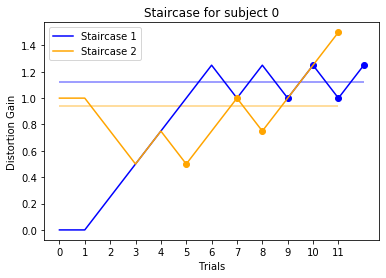

In [20]:
staircase_plot(0) # Plot using line style

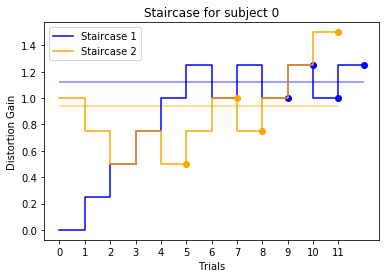

In [21]:
staircase_plot(0, staircase=True) # Plot using staircase style

## Plot the staircase and UCB thresholds

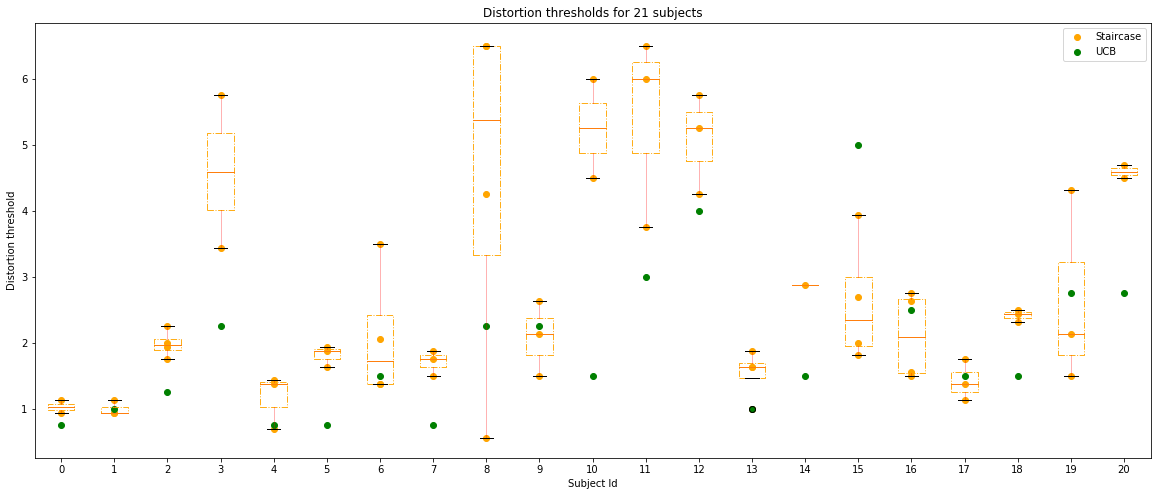

In [22]:
ucb_vals, staircase_vals = get_convergence_values()
plot_ucb_staircase(ucb_vals, staircase_vals, 'Distortion thresholds for 21 subjects')

## Robustness

In [23]:
ucb_vals, staircase_vals = get_convergence_values()
robust_cols = get_robust_table(ucb_vals, staircase_vals)

For subject 0 ucb threshold: 0.75, Robustness: 2.797202797202797%, Conservativeness: 14.685314685314685%
For subject 0 staircase 0, threshold: 1.125, Robustness: 6.293706293706294%, Conservativeness: 11.188811188811188%
For subject 0 staircase 1, threshold: 0.9375, Robustness: 2.797202797202797%, Conservativeness: 14.685314685314685%
Most robust staircase: 2.797202797202797, Least conservative staircase: 6.293706293706294, In middle-staircase: 6.293706293706294, UCB value: 2.797202797202797

For subject 1 ucb threshold: 1.0, Robustness: 6.41025641025641%, Conservativeness: 7.6923076923076925%
For subject 1 staircase 0, threshold: 0.9375, Robustness: 1.282051282051282%, Conservativeness: 22.435897435897438%
For subject 1 staircase 1, threshold: 0.9375, Robustness: 1.282051282051282%, Conservativeness: 22.435897435897438%
For subject 1 staircase 2, threshold: 1.125, Robustness: 6.41025641025641%, Conservativeness: 7.6923076923076925%
Most robust staircase: 1.282051282051282, Least conser

For subject 14 ucb threshold: 1.5, Robustness: 3.64963503649635%, Conservativeness: 28.467153284671532%
For subject 14 staircase 0, threshold: 2.875, Robustness: 21.16788321167883%, Conservativeness: 6.569343065693431%
Most robust staircase: 21.16788321167883, Least conservative staircase: 21.16788321167883, In middle-staircase: 21.16788321167883, UCB value: 3.64963503649635

For subject 15 ucb threshold: 5.0, Robustness: 29.927007299270077%, Conservativeness: 1.4598540145985401%
For subject 15 staircase 0, threshold: 1.8125, Robustness: 5.109489051094891%, Conservativeness: 25.547445255474454%
For subject 15 staircase 1, threshold: 2.0, Robustness: 8.75912408759124%, Conservativeness: 24.087591240875913%
For subject 15 staircase 2, threshold: 3.9375, Robustness: 18.97810218978102%, Conservativeness: 10.948905109489052%
For subject 15 staircase 3, threshold: 2.6875, Robustness: 10.218978102189782%, Conservativeness: 17.51824817518248%
Most robust staircase: 5.109489051094891, Least con

In [24]:
shapiro_tests(robust_cols)

For col 1 stats: 0.875287652015686, p-value: 0.011958244256675243
Not Gaussian (reject H0)

For col 2 stats: 0.9601362943649292, p-value: 0.5188740491867065
Gaussian (fail to reject H0)

For col 3 stats: 0.8848989605903625, p-value: 0.01802637241780758
Not Gaussian (reject H0)

For col 4 stats: 0.8974258303642273, p-value: 0.031203920021653175
Not Gaussian (reject H0)



In [25]:
p_values_robust = wilcoxon_test(robust_cols)

For col 0 - col 1 : Statistics=0.0, p=0.0001318338889828333
Different means (reject H0)

For col 0 - col 2 : Statistics=0.0, p=0.005062032126267864
Different means (reject H0)

For col 0 - col 3 : Statistics=75.0, p=0.9433920568226559
Same means (fail to reject H0)

For col 1 - col 2 : Statistics=0.0, p=0.00043777719457466354
Different means (reject H0)

For col 1 - col 3 : Statistics=9.0, p=0.0003384546789562384
Different means (reject H0)

For col 2 - col 3 : Statistics=37.0, p=0.10894087157711467
Same means (fail to reject H0)



In [26]:
rejects_robust, p_vals_robust = bonferroni_correction(p_values_robust)

H0 rejected: [ True  True False  True  True False]
Corrected p vals: [7.91003334e-04 3.03721928e-02 1.00000000e+00 2.62666317e-03
 2.03072807e-03 6.53645229e-01]
corrected alpha for Bonferroni method: 0.008333333333333333


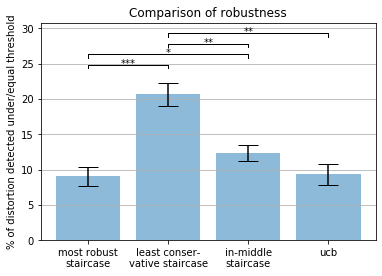

In [27]:
bar_plot(robust_cols, "Comparison of robustness", "% of distortion detected under/equal threshold", rejects_robust, p_vals_robust, h=2, h2=0.5, deltah=1.5)


## Conservativeness

In [28]:
ucb_vals, staircase_vals = get_convergence_values()
conservative_cols = get_conservative_table(ucb_vals, staircase_vals)

For subject 0 ucb threshold: 0.75, Robustness: 2.797202797202797%, Conservativeness: 14.685314685314685%
For subject 0 staircase 0, Threshold: 1.125, Robustness: 6.293706293706294%, Conservativeness: 11.188811188811188%
For subject 0 staircase 1, Threshold: 0.9375, Robustness: 2.797202797202797%, Conservativeness: 14.685314685314685%
Most robust staircase: 14.685314685314685, Least conservative staircase: 11.188811188811188, In middle-staircase: 11.188811188811188, UCB value: 2.797202797202797

For subject 1 ucb threshold: 1.0, Robustness: 6.41025641025641%, Conservativeness: 7.6923076923076925%
For subject 1 staircase 0, Threshold: 0.9375, Robustness: 1.282051282051282%, Conservativeness: 22.435897435897438%
For subject 1 staircase 1, Threshold: 0.9375, Robustness: 1.282051282051282%, Conservativeness: 22.435897435897438%
For subject 1 staircase 2, Threshold: 1.125, Robustness: 6.41025641025641%, Conservativeness: 7.6923076923076925%
Most robust staircase: 22.435897435897438, Least co

For subject 14 ucb threshold: 1.5, Robustness: 3.64963503649635%, Conservativeness: 28.467153284671532%
For subject 14 staircase 0, Threshold: 2.875, Robustness: 21.16788321167883%, Conservativeness: 6.569343065693431%
Most robust staircase: 6.569343065693431, Least conservative staircase: 6.569343065693431, In middle-staircase: 6.569343065693431, UCB value: 3.64963503649635

For subject 15 ucb threshold: 5.0, Robustness: 29.927007299270077%, Conservativeness: 1.4598540145985401%
For subject 15 staircase 0, Threshold: 1.8125, Robustness: 5.109489051094891%, Conservativeness: 25.547445255474454%
For subject 15 staircase 1, Threshold: 2.0, Robustness: 8.75912408759124%, Conservativeness: 24.087591240875913%
For subject 15 staircase 2, Threshold: 3.9375, Robustness: 18.97810218978102%, Conservativeness: 10.948905109489052%
For subject 15 staircase 3, Threshold: 2.6875, Robustness: 10.218978102189782%, Conservativeness: 17.51824817518248%
Most robust staircase: 25.547445255474454, Least co

In [29]:
shapiro_tests(conservative_cols)

For col 1 stats: 0.883427619934082, p-value: 0.016918400302529335
Not Gaussian (reject H0)

For col 2 stats: 0.9796336889266968, p-value: 0.9199962019920349
Gaussian (fail to reject H0)

For col 3 stats: 0.929291844367981, p-value: 0.1332246959209442
Gaussian (fail to reject H0)

For col 4 stats: 0.9561663269996643, p-value: 0.4425136148929596
Gaussian (fail to reject H0)



In [30]:
friedman_test(conservative_cols)

Statistics=36.971590909090885, p=4.6655044082881285e-08
Different distributions (reject H0)



In [31]:
p_values_conservative = wilcoxon_test(conservative_cols)

For col 0 - col 1 : Statistics=0.0, p=0.0001318338889828333
Different means (reject H0)

For col 0 - col 2 : Statistics=0.0, p=0.005062032126267864
Different means (reject H0)

For col 0 - col 3 : Statistics=64.0, p=0.5540338584644351
Same means (fail to reject H0)

For col 1 - col 2 : Statistics=0.0, p=0.00043777719457466354
Different means (reject H0)

For col 1 - col 3 : Statistics=9.0, p=0.0003384546789562384
Different means (reject H0)

For col 2 - col 3 : Statistics=34.0, p=0.07873081119613402
Same means (fail to reject H0)



In [32]:
rejects_conservative, p_vals_conservative = bonferroni_correction(p_values_conservative)

H0 rejected: [ True  True False  True  True False]
Corrected p vals: [7.91003334e-04 3.03721928e-02 1.00000000e+00 2.62666317e-03
 2.03072807e-03 4.72384867e-01]
corrected alpha for Bonferroni method: 0.008333333333333333


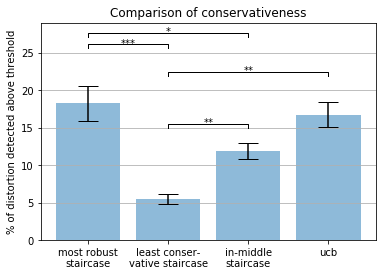

In [33]:
bar_plot(conservative_cols, 'Comparison of conservativeness', '% of distortion detected above threshold', rejects_conservative, p_vals_conservative,  h=2, h2=0.5, deltah=1.5)

## Distortion thresholds

In [34]:
ucb_vals, staircase_vals = get_convergence_values()
threshold_cols = get_table_thresholds(ucb_vals, staircase_vals)

UCB values: [0.75, 1.0, 1.25, 2.25, 0.75, 0.75, 1.5, 0.75, 2.25, 2.25, 1.5, 3.0, 4.0, 1.0, 1.5, 5.0, 2.5, 1.5, 1.5, 2.75, 2.75]
For subject 0 staircase 0, distortion_threshold: 1.125, robustness: 6.293706293706294%, conservativeness: 11.188811188811188%
For subject 0 staircase 1, distortion_threshold: 0.9375, robustness: 2.797202797202797%, conservativeness: 14.685314685314685%
Most robust staircase: indices - ([1]), value: 0.9375; Least conservative staircase: indices - ([0]), value: 1.125; In middle-staircase: indices - ([0]), value: 1.125

For subject 1 staircase 0, distortion_threshold: 0.9375, robustness: 1.282051282051282%, conservativeness: 22.435897435897438%
For subject 1 staircase 1, distortion_threshold: 0.9375, robustness: 1.282051282051282%, conservativeness: 22.435897435897438%
For subject 1 staircase 2, distortion_threshold: 1.125, robustness: 6.41025641025641%, conservativeness: 7.6923076923076925%
Most robust staircase: indices - ([0 1]), value: 0.9375; Least conservat

For subject 16 staircase 1, distortion_threshold: 1.5, robustness: 7.874015748031496%, conservativeness: 28.346456692913385%
For subject 16 staircase 2, distortion_threshold: 2.625, robustness: 17.322834645669293%, conservativeness: 12.598425196850393%
For subject 16 staircase 3, distortion_threshold: 2.75, robustness: 23.62204724409449%, conservativeness: 7.086614173228346%
Most robust staircase: indices - ([0 1]), value: 1.53125; Least conservative staircase: indices - ([3]), value: 2.75; In middle-staircase: indices - ([2]), value: 2.625

For subject 17 staircase 0, distortion_threshold: 1.375, robustness: 6.7669172932330826%, conservativeness: 18.045112781954884%
For subject 17 staircase 1, distortion_threshold: 1.125, robustness: 3.007518796992481%, conservativeness: 24.81203007518797%
For subject 17 staircase 2, distortion_threshold: 1.75, robustness: 21.052631578947366%, conservativeness: 3.7593984962406015%
Most robust staircase: indices - ([1]), value: 1.125; Least conservativ

In [35]:
shapiro_tests(threshold_cols)

For col 1 stats: 0.8614989519119263, p-value: 0.006746652536094189
Not Gaussian (reject H0)

For col 2 stats: 0.9027844667434692, p-value: 0.03963707759976387
Not Gaussian (reject H0)

For col 3 stats: 0.9082279205322266, p-value: 0.05066705495119095
Gaussian (fail to reject H0)

For col 4 stats: 0.8786898255348206, p-value: 0.013813209719955921
Not Gaussian (reject H0)



In [36]:
friedman_test(threshold_cols)

Statistics=38.26203208556148, p=2.4875114334990204e-08
Different distributions (reject H0)



In [37]:
p_values_thresholds = wilcoxon_test(threshold_cols)

For col 0 - col 1 : Statistics=0.0, p=0.0001314204445389205
Different means (reject H0)

For col 0 - col 2 : Statistics=0.0, p=0.005005074402905223
Different means (reject H0)

For col 0 - col 3 : Statistics=86.0, p=0.4778953158937075
Same means (fail to reject H0)

For col 1 - col 2 : Statistics=0.0, p=0.0004358423668112835
Different means (reject H0)

For col 1 - col 3 : Statistics=10.5, p=0.0002615713826673145
Different means (reject H0)

For col 2 - col 3 : Statistics=33.0, p=0.007128810682070169
Different means (reject H0)



In [38]:
rejects_thresholds, p_vals_thresholds = bonferroni_correction(p_values_thresholds)

H0 rejected: [ True  True False  True  True  True]
Corrected p vals: [7.88522667e-04 3.00304464e-02 1.00000000e+00 2.61505420e-03
 1.56942830e-03 4.27728641e-02]
corrected alpha for Bonferroni method: 0.008333333333333333


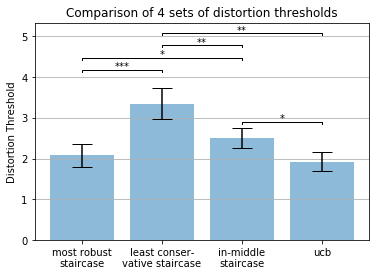

In [39]:
bar_plot(threshold_cols, 'Comparison of 4 sets of distortion thresholds', 'Distortion Threshold', rejects_thresholds, p_vals_thresholds, h=0.1, h2=0.05, deltah=0.3)


## Convergence speed

Subject 0 - Staircase 2: Did not converge
Subject 0 - Staircase 3: Did not converge
Subject 1 - Staircase 2: Did not converge
Subject 3 - Staircase 0: Did not converge
Subject 3 - Staircase 1: Did not converge
Subject 4 - Staircase 2: Did not converge
Subject 5 - Staircase 0: Did not converge
Subject 7 - Staircase 2: Did not converge
Subject 9 - Staircase 2: Did not converge
Subject 10 - Staircase 0: Did not converge
Subject 10 - Staircase 1: Did not converge
Subject 11 - Staircase 0: Did not converge
Subject 12 - Staircase 0: Did not converge
Subject 14 - Staircase 0: Did not converge
Subject 14 - Staircase 1: Did not converge
Subject 14 - Staircase 2: Did not converge
Subject 17 - Staircase 3: Did not converge
Subject 18 - Staircase 0: Did not converge
Subject 19 - Staircase 2: Did not converge
Subject 20 - Staircase 0: Did not converge
Subject 20 - Staircase 1: Did not converge
It takes in average 69.04761904761905 iterations, std: 11.565450150694897, variance: 133.75963718820861 fo

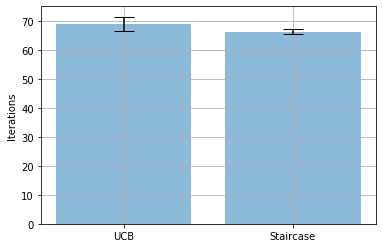

In [40]:
convergence_speed()

## Duration of the trials

In [41]:
positions, normal_times, abnormals, ab_times, ab_paths = load_position()

print("It takes in average {}s +- (standard dev of {})s. There are {} abnormal files:".format(np.mean(normal_times), np.std(normal_times), len(ab_times)))
for t, p in zip(ab_times, ab_paths):
    print("Time: {}, \t Path: {}".format(round(t, 3), p.split('/')[-1]))

It takes in average 6.49563847792s +- (standard dev of 0.5730349937412463)s. There are 63 abnormal files:
Time: 3.083, 	 Path: subjectID_0_Block1_Trial43_20191216_134841.pos.csv
Time: 3.297, 	 Path: subjectID_0_Block1_Trial61_20191216_135120.pos.csv
Time: 2.818, 	 Path: subjectID_1_Block1_Trial151_20191216_155351.pos.csv
Time: 11.194, 	 Path: subjectID_2_Block1_Trial1_20191216_193043.pos.csv
Time: 12.161, 	 Path: subjectID_2_Block1_Trial2_20191216_193059.pos.csv
Time: 2.968, 	 Path: subjectID_2_Block1_Trial36_20191216_193610.pos.csv
Time: 3.586, 	 Path: subjectID_2_Block1_Trial45_20191216_193733.pos.csv
Time: 10.225, 	 Path: subjectID_2_Block3_Trial119_20191216_194925.pos.csv
Time: 3.259, 	 Path: subjectID_4_Block1_Trial42_20191217_113431.pos.csv
Time: 497.936, 	 Path: subjectID_4_Block3_Trial66_20191217_113833.pos.csv
Time: 3.109, 	 Path: subjectID_4_Block5_Trial138_20191217_115741.pos.csv
Time: 3.756, 	 Path: subjectID_5_Block1_Trial14_20191217_132422.pos.csv
Time: 3.768, 	 Path: sub

## Correlation with video gaming

In [42]:
# Load the data from demographic information
demo = '../Data/Demographic Infomation.csv'
demo_df = pd.read_csv(demo)
demo_df.describe()

,Your Age/Votre Âge,ID number/Numéro d'identification
count,21.000000,21.000000
mean,21.142857,10.000000
std,1.904881,6.204837
min,18.000000,0.000000
25%,19.000000,5.000000
50%,21.000000,10.000000
75%,22.000000,15.000000
max,25.000000,20.000000


In [43]:
# Transform the textual data of Hours of Gaming /Week to numerical data
hours = demo_df[demo_df.columns[7]]
hours_dict = {'0': 0, '<1': 0.5, '1-3': 2, '3-5': 4, '5-7': 6, '7-9': 8}
hours = hours.replace(hours_dict).values

In [44]:
staircase_sp_vals, ucb_sp_vals, nb_not_conv_staircase = get_spearman_convergence_values()
taux_conv_staircase = (4 - np.array(nb_not_conv_staircase)) / 4
# Calculate variances & mean
staircase_vars = [np.var(s) for s in staircase_sp_vals]
staircase_mean = [np.mean(s) for s in staircase_sp_vals]

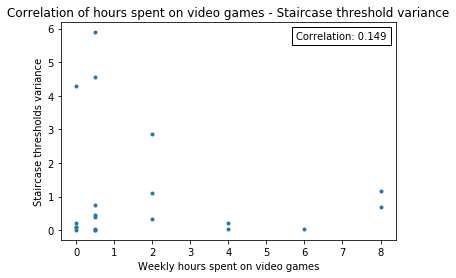

In [45]:
spearman_plot(hours, staircase_vars, 'Correlation of hours spent on video games - Staircase threshold variance', 'Weekly hours spent on video games', 'Staircase thresholds variance', 1)

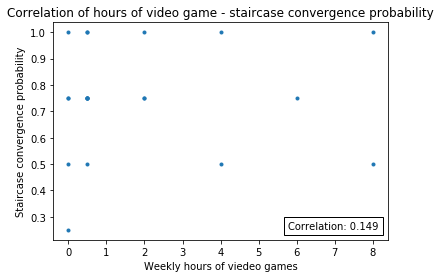

In [46]:
spearman_plot(hours, taux_conv_staircase, 'Correlation of hours of video game - staircase convergence probability', 'Weekly hours of viedeo games', 'Staircase convergence probability')

## Percentage of trials corrected by UCB

In [47]:
for i in SUBJECT_IDS:
    ucb, staircases = load_file_for_subject(i)
    perc = perc_corrected(ucb)
    print("Perc_corrected for subject {} : {} %".format(i, perc))

Perc_corrected for subject 0 : 5.194805194805195 %
Perc_corrected for subject 1 : 3.5294117647058822 %
Perc_corrected for subject 2 : 5.084745762711865 %
Perc_corrected for subject 3 : 7.2727272727272725 %
Perc_corrected for subject 4 : 6.9306930693069315 %
Perc_corrected for subject 5 : 1.7857142857142856 %
Perc_corrected for subject 6 : 12.857142857142856 %
Perc_corrected for subject 7 : 7.317073170731707 %
Perc_corrected for subject 8 : 8.108108108108109 %
Perc_corrected for subject 9 : 8.955223880597014 %
Perc_corrected for subject 10 : 16.666666666666664 %
Perc_corrected for subject 11 : 4.838709677419355 %
Perc_corrected for subject 12 : 9.523809523809524 %
Perc_corrected for subject 13 : 7.4074074074074066 %
Perc_corrected for subject 14 : 8.19672131147541 %
Perc_corrected for subject 15 : 9.58904109589041 %
Perc_corrected for subject 16 : 13.432835820895523 %
Perc_corrected for subject 17 : 9.090909090909092 %
Perc_corrected for subject 18 : 3.125 %
Perc_corrected for subject 1